## Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib
from google.colab.patches import cv2_imshow
import imutils
from PIL import Image
import requests
import re
import statistics as st

## Basic Functions Own

In [ ]:
def normalize(img):
  img_min = np.amin(img)
  img_max = np.amax(img)
  res_img = img - img_min
  res_img = res_img * (1 / (img_max - img_min))
  return res_img

In [ ]:
def zero_cross_detection(image):
  z_c_image = np.zeros(image.shape)
  for i in range(0,image.shape[0]-1):
    for j in range(0,image.shape[1]-1):
      if image[i][j]>0:
          if image[i+1][j] < 0 or image[i+1][j+1] < 0 or image[i][j+1] < 0:
              z_c_image[i,j] = 1
      elif image[i][j] < 0:
          if image[i+1][j] > 0 or image[i+1][j+1] > 0 or image[i][j+1] > 0:
              z_c_image[i,j] = 1
  return 255*z_c_image

In [ ]:
def convolve_2D(original_image,kernel,keep_final_image_same_size = False,pad_left = 2, pad_right = 2, pad_top = 2, pad_bottom = 2, stride_length_x = 1,stride_length_y = 1):
  k_h, k_w = kernel.shape
  if(keep_final_image_same_size):
    pad_x_l = k_w//2
    pad_x_r = k_w - 1 - k_w//2
    pad_y_t = k_h//2
    pad_y_b = k_h - 1 - k_h//2
    stride_x = 1
    stride_y = 1
  else:
    pad_x_l = pad_left
    pad_x_r = pad_right
    pad_y_t = pad_top
    pad_y_b = pad_bottom
    stride_x = stride_length_x
    stride_y = stride_length_y
  og_h, og_w = original_image.shape
  # print(pad_x_l,pad_x_r,pad_y_t,pad_y_b,stride)
  padded_height = og_h + pad_y_t + pad_y_b
  padded_width = og_w + pad_x_l + pad_x_r
  padded_image = np.zeros((padded_height, padded_width))
  for i in range(og_h):
    for j in range(og_w):
      padded_image[pad_y_t+i, pad_x_l+j] = original_image[i,j]
  # print(padded_image)
  output_image = np.zeros(((padded_height-k_h)//stride_x+1,(padded_width-k_w)//stride_y+1))
  out_h, out_w = output_image.shape
  for i in range(out_h):
    for j in range(out_w):
      window = padded_image[i*stride_y:i*stride_y+k_h, j*stride_x:j*stride_x+k_w]
      output_image[i,j] = np.sum(np.multiply(window,kernel))
  return output_image

## Question 1

#### Reading the image

The image needs to be uploaded at runtime before running the below mentioned cell.

In [ ]:
img = cv2.imread("/content/ClownOrig.jpg")

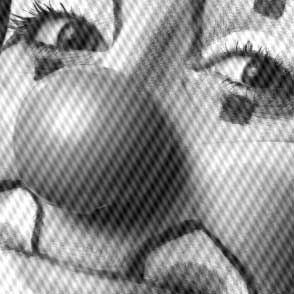

In [ ]:
cv2_imshow(img)

In [ ]:
img.shape

(294, 294, 3)

#### Reparing the color issue and converting to grayscale

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

In [ ]:
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

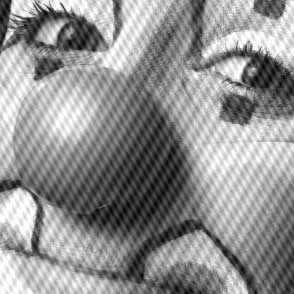

In [ ]:
cv2_imshow(img_gray)

#### Reduce noise in frequency domain

In [ ]:
def low_pass_filter(img):
  # cv2_imshow(img)
  dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)
  # cv2_imshow(dft_shift[:,:,0])
  magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
  # cv2_imshow(magnitude_spectrum)
  rows, cols = img.shape
  mrow,mcol = int(rows/2) , int(cols/2)
  mask = np.zeros((rows,cols,2))
  mask[mrow-20:mrow+20, mcol-20:mcol+20] = 1
  # cv2_imshow(255*mask[:,:,0])
  fshift = dft_shift*mask
  # cv2_imshow(fshift[:,:,0])
  f_ishift = np.fft.ifftshift(fshift)
  # cv2_imshow(f_ishift[:,:,0])
  img_ift = cv2.idft(f_ishift)
  # cv2_imshow(img_ift[:,:,0])
  img_ift = cv2.magnitude(img_ift[:,:,0],img_ift[:,:,1])
  img_blur = 255 * normalize(img_ift)
  return img_blur

In [ ]:
img_freq_blurred = low_pass_filter(img_gray)

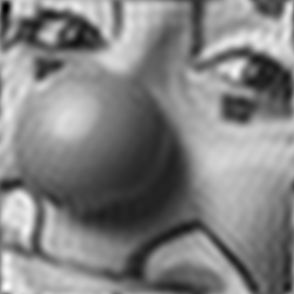

In [ ]:
cv2_imshow(img_freq_blurred)

#### Sharpening filter

In [ ]:
sharp_kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
image_sharp = convolve_2D(img_freq_blurred,sharp_kernel,True)

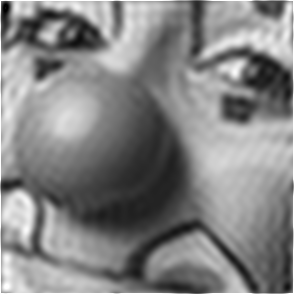

In [ ]:
cv2_imshow(image_sharp)

#### Trying another approach

In [ ]:
def filter_needed(img):
  # cv2_imshow(img)
  dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)
  # cv2_imshow(dft_shift[:,:,0])
  print("Magnitude Spectrum : ")
  magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
  cv2_imshow(magnitude_spectrum)
  rows, cols = img.shape
  mrow,mcol = int(rows/2) , int(cols/2)

  mask_1 = np.zeros((rows,cols,2))
  mask_1[mrow-20:mrow+20, mcol-20:mcol+20] = 1
  print("Mask 1 (Low) : ")
  cv2_imshow(255*mask_1[:,:,0])
  fshift_1 = dft_shift*mask_1
  # cv2_imshow(fshift[:,:,0])
  f_ishift_1 = np.fft.ifftshift(fshift_1)
  # cv2_imshow(f_ishift[:,:,0])
  img_ift_1 = cv2.idft(f_ishift_1)
  # cv2_imshow(img_ift[:,:,0])
  img_ift_1 = cv2.magnitude(img_ift_1[:,:,0],img_ift_1[:,:,1])
  img_low = 255 * normalize(img_ift_1)

  mask_2 = np.zeros((rows,cols,2)) + 1
  mask_2[mrow-50:mrow+50, mcol-50:mcol+50] = 0
  print("Mask 2 (High) : ")
  cv2_imshow(255*mask_2[:,:,0])
  fshift_2 = dft_shift*mask_2
  # cv2_imshow(fshift[:,:,0])
  f_ishift_2 = np.fft.ifftshift(fshift_2)
  # cv2_imshow(f_ishift[:,:,0])
  img_ift_2 = cv2.idft(f_ishift_2)
  # cv2_imshow(img_ift[:,:,0])
  img_ift_2 = cv2.magnitude(img_ift_2[:,:,0],img_ift_2[:,:,1])
  img_high = 255 * normalize(img_ift_2)

  final_img = 255 * normalize(img_high + img_low)

  return final_img

Magnitude Spectrum : 


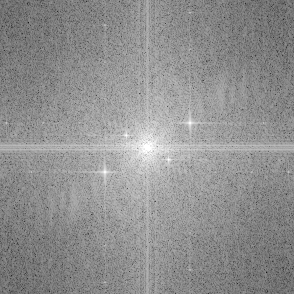

Mask 1 (Low) : 


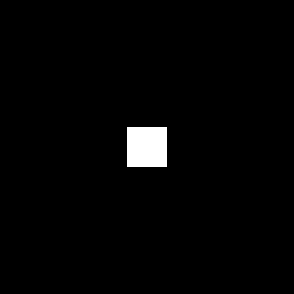

Mask 2 (High) : 


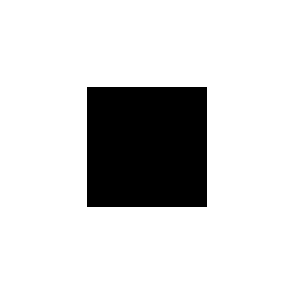

Final Result :


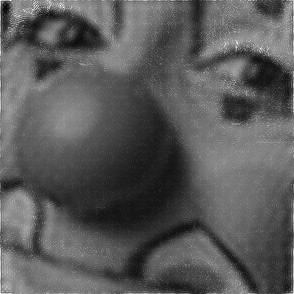

In [ ]:
final_img_2 = filter_needed(img_gray) 
print("Final Result :")
cv2_imshow(final_img_2)

## Question 2

#### Importing Image

In [ ]:
from urllib.request import urlopen
from PIL import Image
import io

In [ ]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQKWD-g0YEkYr5Cq7nf_5i3-onW0GpE5qi1BA&usqp=CAU"

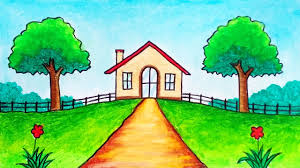

In [ ]:
im_2 = Image.open(urlopen(url))
im_2

#### Resizing Image and Converting to Gray Scale

In [ ]:
im_2 = im_2.resize((256,256))

In [ ]:
img_2 = np.array(im_2)

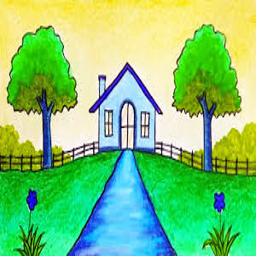

In [ ]:
cv2_imshow(img_2)

In [ ]:
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

Image 2 (grayscale) : 


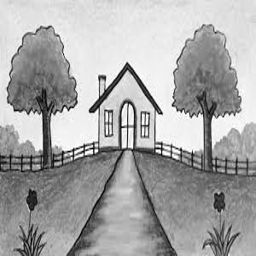

Shape :  (256, 256)


In [ ]:
print("Image 2 (grayscale) : ")
cv2_imshow(img_2_gray)
print("Shape : ",img_2_gray.shape)

#### Computing DoG by taking differences of gaussians

In [ ]:
# Apply 15x15 and 17x17 Gaussian blur
img_2_blur_1 = cv2.GaussianBlur(img_2_gray,(3,3),0)
img_2_blur_2 = cv2.GaussianBlur(img_2_gray,(7,7),0)

# Calculate the DoG by subtracting
img_2_dog = img_2_blur_1 - img_2_blur_2

In [ ]:
img_2_dog = 255 * normalize(img_2_dog)

Difference of Gaussian (DoG) : 


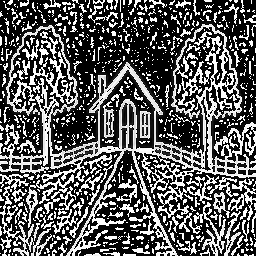

Shape :  (256, 256)


In [ ]:
print("Difference of Gaussian (DoG) : ")
cv2_imshow(img_2_dog)
print("Shape : ",img_2_dog.shape)

#### Computing LoG

In [ ]:
img_2_log = cv2.Laplacian(img_2_blur_2,cv2.CV_64F)

In [ ]:
img_2_log_after_zc = zero_cross_detection(img_2_log)

In [ ]:
img_2_log = 255 * normalize(img_2_log)

Laplacian of Gaussian (LoG) before Zero Crossing : 


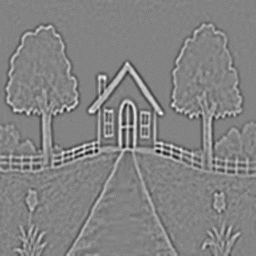

Shape :  (256, 256)


In [ ]:
print("Laplacian of Gaussian (LoG) before Zero Crossing : ")
cv2_imshow(img_2_log)
print("Shape : ",img_2_log.shape)

In [ ]:
img_2_log_after_zc = 255 * normalize(img_2_log_after_zc)

Laplacian of Gaussian (LoG) after Zero Crossing : 


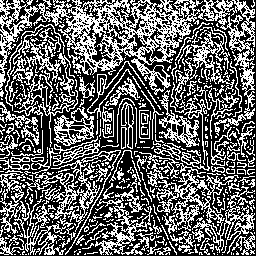

Shape :  (256, 256)


In [ ]:
print("Laplacian of Gaussian (LoG) after Zero Crossing : ")
cv2_imshow(img_2_log_after_zc)
print("Shape : ",img_2_log_after_zc.shape)

Approach:

As we can see that both LoG and DoG give the edges of the original image and are similar in that aspect. In the case of DoG we are applying two blurs and subtracting the higher blurred image from the lower blur image. This results in the left over extra features (edges) of the lesser blurred image and thus we can see the edges.

In the case of LoG, we are using the blur to remove the noise from the original image. Then we are taking the double derivative of the image and using zero-crossing to detect where the value changes from positive to negative and thus the edges (two-layered) are found.